In [1]:
#Importing Pandas
import pandas as pd

#Load Data
df = pd.read_csv('imbalanced_updated.csv')    

#View Data
df.tail()

,Score,Summary
518396,5,Will not do without
518397,2,disappointed
518398,5,Perfect for our maltipoo
518399,5,Favorite Training and reward treat
518400,5,Great Honey


In [2]:
score_counts = df['Score'].value_counts().sort_index()

print(score_counts)

Score
1     46545
2     25588
3     37557
4     73008
5    335703
Name: count, dtype: int64


Text Normalization Code (Clean & Commented)

In [3]:
import re
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources (only first time)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and normalize text
def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs and HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # URLs
    text = re.sub(r'<.*?>', '', text)                    # HTML
    
    # 3. Remove emojis and non-alphabetic characters
    text = re.sub(r'[^\w\s]', '', text)                  # punctuation
    text = re.sub(r'[\d_]', '', text)                    # numbers and underscores
    text = re.sub(r'\s+', ' ', text).strip()             # extra spaces
    
    # 4. Tokenize
    tokens = nltk.word_tokenize(text)
    
    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 6. Lemmatize (convert words to base form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 7. Rejoin tokens
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply cleaning to your dataset
df['cleaned_summary'] = df['Summary'].astype(str).apply(clean_text)

# 8. Filter out reviews with <3 words or extremely long text (>150 words)
df = df[df['cleaned_summary'].apply(lambda x: len(x.split()) >= 3)]
df = df[df['cleaned_summary'].apply(lambda x: len(x.split()) <= 150)]

print("Remaining samples after cleaning:", len(df))
df[['Summary', 'cleaned_summary', 'Score']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Remaining samples after cleaning: 263842


,Summary,cleaned_summary,Score
1,Be careful ordering fragile items online!,careful ordering fragile item online,3
4,LOVE LOVE LOVE,love love love,5
7,Truly Tasty Granola Bars and Bags of Granola,truly tasty granola bar bag granola,5
9,GREAT GF food,great gf food,5
11,Great Granola Bars,great granola bar,4


In [4]:
print(df['cleaned_summary'].head())


1     careful ordering fragile item online
4                           love love love
7      truly tasty granola bar bag granola
9                            great gf food
11                       great granola bar
Name: cleaned_summary, dtype: object


In [5]:
# Count how many reviews per score (1–5)
score_counts = df['Score'].value_counts().sort_index()

print(score_counts)

Score
1     22246
2     12432
3     19818
4     40787
5    168559
Name: count, dtype: int64


we take 20,000 total sample reviews for imbalanced training. with 1 star with 10% , 2 satr with 15%, 3 star with 25%, 4 star with 30% and 5 star with 20%.

In [6]:


# (your cleaning code as before)
df['cleaned_summary'] = df['Summary'].astype(str).apply(clean_text)
df = df[df['cleaned_summary'].apply(lambda x: len(x.split()) >= 3)]
df = df[df['cleaned_summary'].apply(lambda x: len(x.split()) <= 150)]

print("Remaining samples after cleaning:", len(df))

# --- SAMPLING FROM CLEANED DATA ---
sample_sizes = {
    1: 2000,
    2: 3000,
    3: 5000,
    4: 6000,
    5: 4000
}

sampled_parts = []
for score, n in sample_sizes.items():
    subset = df[df['Score'] == score].sample(n=n, random_state=42)
    sampled_parts.append(subset)

sampled_df = pd.concat(sampled_parts, ignore_index=True)
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: view counts
sampled_df['Score'].value_counts().sort_index()


Remaining samples after cleaning: 263842


Score
1    2000
2    3000
3    5000
4    6000
5    4000
Name: count, dtype: int64

SAVE THE FILE

In [7]:
# --- SAVE THE FILE ---
output_path = "the_real_imbalanced.csv"
sampled_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ File saved successfully as: {output_path}")

✅ File saved successfully as: the_real_imbalanced.csv


test train split

In [7]:
from sklearn.model_selection import train_test_split

# Load the cleaned and sampled data
sampled_df = pd.read_csv("the_real_imbalanced.csv")

# Verify the data
print("Total samples:", len(sampled_df))
print("\nClass distribution:")
print(sampled_df['Score'].value_counts().sort_index())

# Perform 80:20 train-test split with stratification
# stratify ensures each split maintains the same class distribution
X = sampled_df['cleaned_summary']
y = sampled_df['Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # for reproducibility
    stratify=y               # maintains class balance in both splits
)

# Create train and test dataframes
train_df = pd.DataFrame({
    'cleaned_summary': X_train,
    'Score': y_train
})

test_df = pd.DataFrame({
    'cleaned_summary': X_test,
    'Score': y_test
})

# Display split information
print("\n--- Split Summary ---")
print(f"Training set size: {len(train_df)} ({len(train_df)/len(sampled_df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(sampled_df)*100:.1f}%)")

print("\nTraining set distribution:")
print(train_df['Score'].value_counts().sort_index())

print("\nTest set distribution:")
print(test_df['Score'].value_counts().sort_index())

# Save the splits to separate CSV files
train_df.to_csv("train_data.csv", index=False, encoding='utf-8')
test_df.to_csv("test_data.csv", index=False, encoding='utf-8')

print("\n✅ Files saved successfully:")
print("   - train_data.csv")
print("   - test_data.csv")

Total samples: 20000

Class distribution:
Score
1    2000
2    3000
3    5000
4    6000
5    4000
Name: count, dtype: int64

--- Split Summary ---
Training set size: 16000 (80.0%)
Test set size: 4000 (20.0%)

Training set distribution:
Score
1    1600
2    2400
3    4000
4    4800
5    3200
Name: count, dtype: int64

Test set distribution:
Score
1     400
2     600
3    1000
4    1200
5     800
Name: count, dtype: int64

✅ Files saved successfully:
   - train_data.csv
   - test_data.csv


training onn best model

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import time

# Load train and test data
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

X_train = train_df['cleaned_summary']
y_train = train_df['Score']
X_test = test_df['cleaned_summary']
y_test = test_df['Score']

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("\n" + "="*60)

# ============================================
# STEP 1: VECTORIZATION
# ============================================
print("\n🔄 Converting text to TF-IDF features...")

vectorizer = TfidfVectorizer(
    max_features=5000,      # limit to top 5000 features
    ngram_range=(1, 2),     # unigrams and bigrams
    min_df=2,               # ignore terms that appear in less than 2 documents
    max_df=0.8              # ignore terms that appear in more than 80% of documents
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✅ Feature matrix shape: {X_train_tfidf.shape}")
print("="*60)

# ============================================
# STEP 2: TRAIN MODELS
# ============================================

models = {}
results = {}

# --- Logistic Regression ---
print("\n🔄 Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    multi_class='multinomial',
    class_weight='balanced'  # handles class imbalance
)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_time = time.time() - start_time

models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'predictions': lr_pred,
    'training_time': lr_time
}

print(f"✅ Logistic Regression - Accuracy: {lr_accuracy:.4f} | Time: {lr_time:.2f}s")

# --- Random Forest ---
print("\n🔄 Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,  # use all CPU cores
    class_weight='balanced'
)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_time = time.time() - start_time

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'predictions': rf_pred,
    'training_time': rf_time
}

print(f"✅ Random Forest - Accuracy: {rf_accuracy:.4f} | Time: {rf_time:.2f}s")

# --- Linear SVM ---
print("\n🔄 Training Linear SVM...")
start_time = time.time()

svm_model = LinearSVC(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_time = time.time() - start_time

models['Linear SVM'] = svm_model
results['Linear SVM'] = {
    'accuracy': svm_accuracy,
    'predictions': svm_pred,
    'training_time': svm_time
}

print(f"✅ Linear SVM - Accuracy: {svm_accuracy:.4f} | Time: {svm_time:.2f}s")

# ============================================
# STEP 3: COMPARE MODELS
# ============================================
print("\n" + "="*60)
print("📊 MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
best_accuracy = comparison_df.iloc[0]['Accuracy']
best_predictions = results[best_model_name]['predictions']

print(f"\n🏆 BEST MODEL: {best_model_name} (Accuracy: {best_accuracy:.4f})")

# ============================================
# STEP 4: DETAILED EVALUATION OF BEST MODEL
# ============================================
print("\n" + "="*60)
print(f"📈 DETAILED EVALUATION - {best_model_name}")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=[f"Score {i}" for i in range(1, 6)]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_predictions)
cm_df = pd.DataFrame(cm, 
                     index=[f"True {i}" for i in range(1, 6)],
                     columns=[f"Pred {i}" for i in range(1, 6)])
print(cm_df)

# ============================================
# STEP 5: SAVE BEST MODEL AND VECTORIZER
# ============================================
print("\n" + "="*60)
print("💾 SAVING BEST MODEL")
print("="*60)

# Save the best model
model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save the vectorizer (IMPORTANT - needed for making predictions on new data)
vectorizer_filename = "tfidf_vectorizer.pkl"
joblib.dump(vectorizer, vectorizer_filename)
print(f"✅ Vectorizer saved as: {vectorizer_filename}")

# Save results summary
summary = {
    'best_model': best_model_name,
    'accuracy': float(best_accuracy),
    'all_results': {k: {'accuracy': float(v['accuracy']), 
                        'training_time': float(v['training_time'])} 
                    for k, v in results.items()}
}


print("\n" + "="*60)
print("✨ TRAINING COMPLETE!")
print(f"\n🏆 MODEL B: {best_model_name} (Accuracy: {best_accuracy:.4f})")

print("="*60)



Training set size: 16000
Test set size: 4000


🔄 Converting text to TF-IDF features...
✅ Feature matrix shape: (16000, 5000)

🔄 Training Logistic Regression...


c:\Users\91940\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression - Accuracy: 0.4377 | Time: 2.49s

🔄 Training Random Forest...
✅ Random Forest - Accuracy: 0.4828 | Time: 9.57s

🔄 Training Linear SVM...
✅ Linear SVM - Accuracy: 0.4425 | Time: 0.46s

📊 MODEL COMPARISON
              Model  Accuracy  Training Time (s)
      Random Forest   0.48275           9.566001
         Linear SVM   0.44250           0.462611
Logistic Regression   0.43775           2.486049

🏆 BEST MODEL: Random Forest (Accuracy: 0.4828)

📈 DETAILED EVALUATION - Random Forest

Classification Report:
              precision    recall  f1-score   support

     Score 1       0.44      0.38      0.41       400
     Score 2       0.50      0.34      0.40       600
     Score 3       0.47      0.48      0.47      1000
     Score 4       0.50      0.59      0.54      1200
     Score 5       0.48      0.48      0.48       800

    accuracy                           0.48      4000
   macro avg       0.48      0.45      0.46      4000
weighted avg       0.48      0.48 

test of model A

In [18]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
import seaborn as sns
import matplotlib.pyplot as plt



model_path = '../../Models/Model_A_linear_svm.pkl'
vectorizer_path = '../../Models/Model_A_vectorizer.pkl'

def diagnose_pickle_file(file_path):
    
    print(f"\n📁 Checking: {file_path}")
    
    
# Diagnose both files
model_valid = diagnose_pickle_file(model_path)
vectorizer_valid = diagnose_pickle_file(vectorizer_path)



def safe_pickle_load(file_path, description):
    
    print(f"\n🔄 Loading {description}...")
    
    # Method 1: Standard pickle load
    try:
        with open(file_path, 'rb') as f:
            obj = pickle.load(f)
       
        return obj, True
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
    
    # Method 2: Try different pickle protocols
    for protocol in range(6):
        try:
            with open(file_path, 'rb') as f:
                obj = pickle.load(f, encoding='latin1')
           
            return obj, True
        except:
            pass
    
    # Method 3: Check if it's a joblib file instead
    try:
        import joblib
        obj = joblib.load(file_path)
       
        return obj, True
    except Exception as e:
        print(f" {type(e).__name__}")
    
    print(f" {description}")
    return None, False

# Try to load model
model, model_loaded = safe_pickle_load(model_path, "model")

# Try to load vectorizer
vectorizer, vectorizer_loaded = safe_pickle_load(vectorizer_path, "vectorizer")

# --- PROCEED WITH EVALUATION IF FILES LOADED ---
if model_loaded and vectorizer_loaded:
    print("\n" + "="*60)
    print("✅ MODEL A TEST DATA")
    print("="*60)
    
    # --- LOAD TEST DATA ---
    print("\nLoading test data...")
    test_df = pd.read_csv("test_data.csv")
    X_test = test_df['cleaned_summary']
    y_test = test_df['Score']
    
    print(f"Test set size: {len(test_df)} samples")
    print(f"\nClass distribution in test set:")
    print(y_test.value_counts().sort_index())
    
    # --- VECTORIZE TEST DATA ---
    print("\nVectorizing test data...")
    X_test_vec = vectorizer.transform(X_test)
    print(f"Feature matrix shape: {X_test_vec.shape}")
    
    # --- MAKE PREDICTIONS ---
    print("\nMaking predictions...")
    y_pred = model.predict(X_test_vec)
    
    # --- CALCULATE METRICS ---
    print("\n" + "="*60)
    print("MODEL A TEST ACCURACY RESULTS")
    print("="*60)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Weighted F1-Score: {f1_weighted:.4f}")
    print(f"  Macro F1-Score:    {f1_macro:.4f}")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    
    print("\n" + "-"*60)
    print("Detailed Classification Report:")
    print("-"*60)
    print(classification_report(y_test, y_pred, target_names=[f'Score {i}' for i in range(1, 6)]))
    
    
    
    # --- PER-CLASS ANALYSIS ---
    print("\n" + "="*60)
    print("PER-CLASS PERFORMANCE")
    print("="*60)
    
    per_class_results = []
    for i in range(1, 6):
        mask = y_test == i
        if mask.sum() > 0:
            class_accuracy = (y_pred[mask] == i).sum() / mask.sum()
            per_class_results.append({
                'Score': i,
                'Count': mask.sum(),
                'Correct': (y_pred[mask] == i).sum(),
                'Accuracy': class_accuracy
            })
    
    per_class_df = pd.DataFrame(per_class_results)
    print(per_class_df.to_string(index=False))
    
    
    
else:
    print("\n" + "="*60)
    print("❌ CANNOT PROCEED - FILES FAILED TO LOAD")
    print("="*60)
    print("\n🔧 TROUBLESHOOTING SUGGESTIONS:")
    print("\n1. Check if files were saved with joblib instead of pickle:")
    print("   Try: import joblib; model = joblib.load('model_path')")
    print("\n2. Verify the model was saved correctly during training")
    print("\n3. Check if the file path is correct")
    print("\n4. Ensure the files aren't corrupted (check file sizes)")
    print("\n5. If files were created on different OS/Python version, try:")
    print("   pickle.load(f, encoding='latin1')")
    print("\n6. Re-train and save the model if files are corrupted")


📁 Checking: ../../Models/Model_A_linear_svm.pkl

📁 Checking: ../../Models/Model_A_vectorizer.pkl

🔄 Loading model...
UnpicklingError: invalid load key, '\x0b'.

🔄 Loading vectorizer...
UnpicklingError: invalid load key, '\x07'.

✅ MODEL A TEST DATA

Loading test data...
Test set size: 4000 samples

Class distribution in test set:
Score
1     400
2     600
3    1000
4    1200
5     800
Name: count, dtype: int64

Vectorizing test data...
Feature matrix shape: (4000, 5000)

Making predictions...

MODEL A TEST ACCURACY RESULTS

Overall Metrics:
  Accuracy:          0.4000 (40.00%)
  Weighted F1-Score: 0.3996
  Macro F1-Score:    0.3968
  Precision:         0.4120
  Recall:            0.4000

------------------------------------------------------------
Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Score 1       0.32      0.55      0.40       400
     Score 2       0.32      0.37      

Import Visualization Libraries

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set a clean visual style
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)





Bar Plot — Review Count per Rating

C:\Users\91940\AppData\Local\Temp\ipykernel_20316\2137379531.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sampled_df, x='Score', palette='viridis', edgecolor='black')


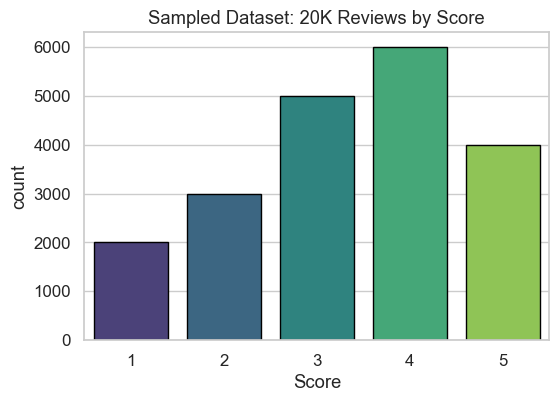

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example visualization
plt.figure(figsize=(6,4))
sns.countplot(data=sampled_df, x='Score', palette='viridis', edgecolor='black')
plt.title('Sampled Dataset: 20K Reviews by Score')
plt.show()


Display 3–10 Sample Reviews per Rating

In [8]:
# Display random sample reviews for each rating
for rating in sorted(df['Score'].unique()):
    print(f"\n{'='*40}")
    print(f"⭐ Rating: {rating}")
    print(f"{'='*40}")
    
    samples = df[df['Score'] == rating].sample(n=min(5, len(df[df['Score'] == rating])), random_state=42)
    for i, review in enumerate(samples['cleaned_summary'], 1):
        print(f"{i}. {review}\n")



⭐ Rating: 1
1. inferior quality goji berry

2. even good rat bait

3. rainbow match photo whatsoever

4. new formula ingredient match amazon description

5. there hole bagwatch


⭐ Rating: 2
1. like lowcarb snack

2. might good smaller dog large one

3. dent like road kill

4. much smaller expected

5. may work squirrel absolutely chipmunk


⭐ Rating: 3
1. mccormick beware updated review

2. nice aroma lacking bit vanilla flavour

3. good taste high sucrose content

4. salty good kick

5. good coffee bean little stale


⭐ Rating: 4
1. yummmmm banana laffy taffy

2. like chocolatecovered cherry

3. nice smooth espresso

4. dog love ita little pricey

5. woof woof grrrr grrrrrrr yummm mmmmmmm


⭐ Rating: 5
1. best product best price

2. best dog treat

3. keep bottle handalways

4. perfect base making puttanesca

5. found chewing gum amazoncom



train

In [19]:
# ========================================
# SCRIPT 1: IMPROVED TRAINING PIPELINE
# File: train_model.py
# ========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack
from textblob import TextBlob
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("IMPROVED SENTIMENT ANALYSIS TRAINING PIPELINE")
print("=" * 70)

# ========================================
# ENHANCED PREPROCESSING
# ========================================
def advanced_text_cleaning(text):
    """Enhanced text cleaning with better negation handling"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Preserve negations more aggressively
    negation_words = ['not', 'no', 'never', 'neither', 'nobody', 'nothing', 
                      'nowhere', 'none', "n't", 'dont', 'wont', 'cant', 'shouldnt']
    for word in negation_words:
        text = re.sub(rf'\b{word}\b', f'NOT_{word}', text)
    
    # Preserve important contrasts
    text = text.replace(' but ', ' BUT_CONTRAST ')
    text = text.replace(' however ', ' HOWEVER_CONTRAST ')
    text = text.replace(' although ', ' ALTHOUGH_CONTRAST ')
    
    # Remove noise
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?._]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def extract_enhanced_features(df, text_column):
    """Enhanced feature extraction"""
    features = pd.DataFrame()
    
    # Basic features
    features['text_length'] = df[text_column].str.len()
    features['word_count'] = df[text_column].str.split().str.len()
    features['avg_word_length'] = features['text_length'] / (features['word_count'] + 1)
    features['unique_word_ratio'] = df[text_column].apply(
        lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1)
    )
    
    # Punctuation & emphasis
    features['exclamation_count'] = df[text_column].str.count(r'!')
    features['question_count'] = df[text_column].str.count(r'\?')
    features['period_count'] = df[text_column].str.count(r'\.')
    features['uppercase_ratio'] = df[text_column].str.count(r'[A-Z]') / (features['text_length'] + 1)
    features['all_caps_words'] = df[text_column].apply(
        lambda x: sum(1 for word in str(x).split() if word.isupper() and len(word) > 1)
    )
    
    # Enhanced negation detection
    features['negation_count'] = df[text_column].str.count(r'NOT_')
    features['but_count'] = df[text_column].str.count(r'BUT_CONTRAST|HOWEVER_CONTRAST|ALTHOUGH_CONTRAST')
    features['has_negation'] = (features['negation_count'] > 0).astype(int)
    features['has_contrast'] = (features['but_count'] > 0).astype(int)
    
    # Sentiment analysis
    sentiments = df[text_column].apply(lambda x: TextBlob(str(x)).sentiment)
    features['sentiment_polarity'] = sentiments.apply(lambda x: x.polarity)
    features['sentiment_subjectivity'] = sentiments.apply(lambda x: x.subjectivity)
    features['polarity_abs'] = features['sentiment_polarity'].abs()
    features['polarity_squared'] = features['sentiment_polarity'] ** 2
    
    # Interaction features
    features['negation_polarity_interaction'] = features['negation_count'] * features['sentiment_polarity']
    features['contrast_polarity_interaction'] = features['but_count'] * features['sentiment_polarity']
    
    # Enhanced word lists
    strong_positive = ['excellent', 'amazing', 'wonderful', 'perfect', 'awesome', 
                      'fantastic', 'outstanding', 'delicious', 'best', 'love',
                      'great', 'superb', 'brilliant', 'incredible', 'phenomenal']
    strong_negative = ['terrible', 'awful', 'horrible', 'disgusting', 'worst', 
                      'waste', 'disappointed', 'hate', 'bad', 'poor',
                      'useless', 'pathetic', 'nasty', 'gross', 'dreadful']
    moderate_positive = ['good', 'nice', 'fine', 'okay', 'decent', 'pleasant']
    moderate_negative = ['mediocre', 'bland', 'boring', 'meh', 'average']
    
    features['strong_positive_count'] = df[text_column].apply(
        lambda x: sum(1 for word in strong_positive if word in str(x).lower())
    )
    features['strong_negative_count'] = df[text_column].apply(
        lambda x: sum(1 for word in strong_negative if word in str(x).lower())
    )
    features['moderate_positive_count'] = df[text_column].apply(
        lambda x: sum(1 for word in moderate_positive if word in str(x).lower())
    )
    features['moderate_negative_count'] = df[text_column].apply(
        lambda x: sum(1 for word in moderate_negative if word in str(x).lower())
    )
    
    features['sentiment_word_score'] = (
        (features['strong_positive_count'] * 2) + features['moderate_positive_count'] -
        (features['strong_negative_count'] * 2) - features['moderate_negative_count']
    )
    
    # Negation impact
    features['negated_positive'] = features['negation_count'] * features['strong_positive_count']
    features['negated_negative'] = features['negation_count'] * features['strong_negative_count']
    
    features = features.fillna(0)
    return features

# ========================================
# LOAD AND PREPARE DATA
# ========================================
print("\n📂 Loading training dataset...")
train_df = pd.read_csv('imbalanced_updated.csv')  # ← CHANGE THIS

print(f"Total available samples: {len(train_df)}")

# ========================================
# PREPROCESS FIRST
# ========================================
print("\n📝 Preprocessing ALL data first...")
train_df['cleaned_summary'] = train_df['Summary'].astype(str).apply(advanced_text_cleaning)
train_df['word_count_temp'] = train_df['cleaned_summary'].str.split().str.len()

# More lenient filtering to keep more samples
print(f"Before filtering: {len(train_df)} samples")
train_df_filtered = train_df[
    (train_df['word_count_temp'] >= 2) &  # Changed from 3 to 2
    (train_df['word_count_temp'] <= 200)  # Changed from 150 to 200
].copy()
train_df_filtered = train_df_filtered.drop('word_count_temp', axis=1)
print(f"After filtering: {len(train_df_filtered)} samples")

print("\nClass distribution after filtering:")
print(train_df_filtered['Score'].value_counts().sort_index())

# ========================================
# SMARTER SAMPLING STRATEGY
# ========================================
print("\n📊 Creating training dataset with improved sampling...")

# More balanced distribution to reduce class imbalance
train_sample_sizes = {
    1: 3000,   # 15% (increased from 10%)
    2: 3500,   # 17.5% (increased from 15%)
    3: 4500,   # 22.5% (decreased from 25%)
    4: 5000,   # 25% (decreased from 30%)
    5: 4000    # 20%
}

train_sampled_parts = []
for score, n in train_sample_sizes.items():
    subset = train_df_filtered[train_df_filtered['Score'] == score]
    if len(subset) >= n:
        subset = subset.sample(n=n, random_state=42)
        print(f"  Class {score}: Sampled {n} from {len(subset)} available")
    else:
        print(f"  ⚠️ Class {score}: Only {len(subset)} samples available, using all")
        subset = subset.copy()
    train_sampled_parts.append(subset)

train_data = pd.concat(train_sampled_parts, ignore_index=True)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n📊 Final training distribution:")
print(train_data['Score'].value_counts().sort_index())
print(f"✅ Total training samples: {len(train_data)}")

# ========================================
# EXTRACT FEATURES
# ========================================
print("\n🔧 Extracting enhanced features...")
train_features = extract_enhanced_features(train_data, 'cleaned_summary')
print(f"  Extracted {train_features.shape[1]} features")

X_train_text = train_data['cleaned_summary']
y_train = train_data['Score']

# ========================================
# IMPROVED VECTORIZATION
# ========================================
print("\n🔤 Vectorizing text with improved parameters...")
vectorizer = TfidfVectorizer(
    max_features=8000,  # Increased from 6000
    ngram_range=(1, 3),  # Added trigrams
    min_df=3,  # More lenient
    max_df=0.85,  # More lenient
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    use_idf=True,
    smooth_idf=True,
    norm='l2'
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)

print("🔗 Combining features...")
scaler = StandardScaler(with_mean=False)  # Important for sparse matrices
train_features_scaled = scaler.fit_transform(train_features)

X_train_combined = hstack([X_train_tfidf, train_features_scaled])
print(f"Training feature shape: {X_train_combined.shape}")

# ========================================
# CALCULATE CLASS WEIGHTS
# ========================================
print("\n⚖️  Calculating optimized class weights...")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Smooth weights to avoid over-penalization
max_weight = max(class_weight_dict.values())
for k in class_weight_dict:
    class_weight_dict[k] = min(class_weight_dict[k], max_weight * 0.8)

print("Smoothed class weights:")
for class_label, weight in class_weight_dict.items():
    count = (y_train == class_label).sum()
    print(f"  Class {class_label}: {weight:.3f} (n={count})")

# ========================================
# TRAIN MULTIPLE MODELS
# ========================================
print("\n" + "=" * 70)
print("TRAINING IMPROVED MODELS")
print("=" * 70)

models = {}
cv_results = {}

# Create scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. Logistic Regression with optimized parameters
print("\n1️⃣  Training Logistic Regression (optimized)...")
lr_optimized = LogisticRegression(
    C=1.0,  # Increased regularization strength
    class_weight=class_weight_dict,
    max_iter=3000,
    random_state=42,
    solver='saga',  # Better for large datasets
    penalty='l2',
    multi_class='multinomial'
)

print("   Performing cross-validation...")
cv_scores_lr = cross_val_score(
    lr_optimized, X_train_combined, y_train,
    cv=skf, scoring=f1_macro_scorer, n_jobs=-1
)
print(f"   CV Macro F1: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

lr_optimized.fit(X_train_combined, y_train)
models['lr_optimized'] = lr_optimized
cv_results['lr_optimized'] = cv_scores_lr.mean()

# 2. Calibrated Logistic Regression
print("\n2️⃣  Training Calibrated LR...")
calibrated_lr = CalibratedClassifierCV(
    lr_optimized,
    method='sigmoid',  # Changed from isotonic
    cv=3  # Reduced for speed
)

print("   Fitting calibrated model...")
calibrated_lr.fit(X_train_combined, y_train)

print("   Performing cross-validation...")
cv_scores_cal = cross_val_score(
    CalibratedClassifierCV(lr_optimized, method='sigmoid', cv=3),
    X_train_combined, y_train,
    cv=skf, scoring=f1_macro_scorer, n_jobs=-1
)
print(f"   CV Macro F1: {cv_scores_cal.mean():.4f} (+/- {cv_scores_cal.std():.4f})")

models['lr_calibrated'] = calibrated_lr
cv_results['lr_calibrated'] = cv_scores_cal.mean()

# 3. Random Forest with optimized parameters
print("\n3️⃣  Training Random Forest (optimized)...")
rf_optimized = RandomForestClassifier(
    n_estimators=300,  # Increased
    max_depth=25,  # Slightly increased
    min_samples_split=8,
    min_samples_leaf=3,
    class_weight=class_weight_dict,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

print("   Performing cross-validation...")
cv_scores_rf = cross_val_score(
    rf_optimized, X_train_combined, y_train,
    cv=skf, scoring=f1_macro_scorer, n_jobs=-1
)
print(f"   CV Macro F1: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

rf_optimized.fit(X_train_combined, y_train)
print(f"   OOB Score: {rf_optimized.oob_score_:.4f}")
models['rf_optimized'] = rf_optimized
cv_results['rf_optimized'] = cv_scores_rf.mean()

# 4. Gradient Boosting (NEW)
print("\n4️⃣  Training Gradient Boosting (NEW)...")
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42,
    verbose=0
)

print("   Performing cross-validation...")
cv_scores_gb = cross_val_score(
    gb, X_train_combined, y_train,
    cv=skf, scoring=f1_macro_scorer, n_jobs=-1
)
print(f"   CV Macro F1: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})")

gb.fit(X_train_combined, y_train)
models['gradient_boosting'] = gb
cv_results['gradient_boosting'] = cv_scores_gb.mean()

# ========================================
# SELECT BEST MODEL
# ========================================
print("\n" + "=" * 70)
print("MODEL SELECTION")
print("=" * 70)

print(f"\n{'Model':<25} {'CV Macro F1':<15} {'Std Dev':<10}")
print("-" * 50)
all_cv_scores = {
    'lr_optimized': cv_scores_lr,
    'lr_calibrated': cv_scores_cal,
    'rf_optimized': cv_scores_rf,
    'gradient_boosting': cv_scores_gb
}

for model_name, scores in all_cv_scores.items():
    print(f"{model_name:<25} {scores.mean():<15.4f} {scores.std():<10.4f}")

best_model_name = max(cv_results.items(), key=lambda x: x[1])[0]
best_model = models[best_model_name]
best_cv_score = cv_results[best_model_name]

print(f"\n Model_B: {best_model_name}")
print(f"   CV Macro F1: {best_cv_score:.4f}")

# Get training predictions for best model
y_train_pred = best_model.predict(X_train_combined)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

print(f"   Training Accuracy: {train_accuracy:.4f}")
print(f"   Training Macro F1: {train_f1_macro:.4f}")

# ========================================
# SAVE EVERYTHING
# ========================================
print("\n" + "=" * 70)
print("SAVING MODEL AND ARTIFACTS")
print("=" * 70)

with open('model_B.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✅ model_B.pkl")

with open('model_B_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("✅ model_B_vectorizer.pkl")

with open('model_B_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ model_B_scaler.pkl")

metadata = {
    'best_model_name': best_model_name,
    'training_distribution': train_sample_sizes,
    'train_samples': len(train_data),
    'feature_names': list(train_features.columns),
    'train_accuracy': train_accuracy,
    'train_f1_macro': train_f1_macro,
    'cv_f1_macro': best_cv_score,
    'cv_f1_std': all_cv_scores[best_model_name].std(),
    'class_weights': class_weight_dict,
    'all_cv_results': {k: v for k, v in cv_results.items()},
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_B_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✅ model_B_metadata.pkl")

print("\n" + "=" * 70)
print("✨ TRAINING COMPLETE!")
print("=" * 70)

print(f"\n📊 Summary:")
print(f"   • Model: {best_model_name}")
print(f"   • Training samples: {len(train_data)}")
print(f"   • Features: {X_train_combined.shape[1]}")
print(f"   • Training Accuracy: {train_accuracy:.4f}")
print(f"   • Training Macro F1: {train_f1_macro:.4f}")
print(f"   • CV Macro F1: {best_cv_score:.4f} (+/- {all_cv_scores[best_model_name].std():.4f})")

print(f"\n➡️  Next: Run test_model.py with your test dataset")

IMPROVED SENTIMENT ANALYSIS TRAINING PIPELINE

📂 Loading training dataset...
Total available samples: 518401

📝 Preprocessing ALL data first...
Before filtering: 518401 samples
After filtering: 466963 samples

Class distribution after filtering:
Score
1     40669
2     23185
3     35148
4     68032
5    299929
Name: count, dtype: int64

📊 Creating training dataset with improved sampling...
  Class 1: Sampled 3000 from 3000 available
  Class 2: Sampled 3500 from 3500 available
  Class 3: Sampled 4500 from 4500 available
  Class 4: Sampled 5000 from 5000 available
  Class 5: Sampled 4000 from 4000 available

📊 Final training distribution:
Score
1    3000
2    3500
3    4500
4    5000
5    4000
Name: count, dtype: int64
✅ Total training samples: 20000

🔧 Extracting enhanced features...
  Extracted 26 features

🔤 Vectorizing text with improved parameters...
🔗 Combining features...
Training feature shape: (20000, 5564)

⚖️  Calculating optimized class weights...
Smoothed class weights:
  Cl

testing of model_A

In [11]:
"""
test_imbalanced.py
==================
Test Gradient Boosting model (trained on BALANCED data) against IMBALANCED test set
Test distribution: Realistic imbalanced distribution (20,000 samples)

Prerequisites:
    - balanced_trained_model.pkl (Gradient Boosting)
    - balanced_trained_vectorizer.pkl
    - balanced_trained_scaler.pkl
    - balanced_trained_metadata.pkl
"""

import pandas as pd
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score,
                             precision_recall_fscore_support)
from sklearn.preprocessing import label_binarize
from scipy.sparse import hstack
from textblob import TextBlob
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("TESTING GRADIENT BOOSTING ON IMBALANCED DATASET")
print("=" * 70)

# ========================================
# CONFIGURATION
# ========================================
TEST_DATA_FILE = 'imbalanced_updated.csv'  # ← CHANGE THIS
RANDOM_SEED = 42

# Imbalanced test distribution (20,000 total)
TEST_DISTRIBUTION = {
    1: 2000,   # 10% - Very negative (Minority)
    2: 3000,   # 15% - Negative (Minority)
    3: 5000,   # 25% - Neutral (Balanced)
    4: 6000,   # 30% - Positive (Majority)
    5: 4000    # 20% - Very positive (Balanced)
}

# ========================================
# LOAD TRAINED ARTIFACTS
# ========================================
print("\n📦 Loading trained Gradient Boosting model and artifacts...")

required_files = {
    '../../Models/model_A.pkl': 'model',
    '../../Models/model_A_vectorizer.pkl': 'vectorizer',
    '../../Models/model_A_scaler.pkl': 'scaler',
    '../../Models/model_A_metadata.pkl': 'metadata'
}

loaded_artifacts = {}

for filename, var_name in required_files.items():
    try:
        with open(filename, 'rb') as f:
            loaded_artifacts[var_name] = pickle.load(f)
        print(f"  ✅ {filename}")
    except FileNotFoundError:
        print(f"  ❌ {filename} not found!")
        print(f"\n⚠️  Error: Missing required files")
        print(f"     Please run train_balanced.py first!")
        exit(1)

model = loaded_artifacts['model']
vectorizer = loaded_artifacts['vectorizer']
scaler = loaded_artifacts['scaler']
metadata = loaded_artifacts['metadata']

print("\n" + "=" * 70)
print("MODEL INFORMATION")
print("=" * 70)
print(f"Training Type: {metadata.get('training_type', 'BALANCED')}")
print(f"Model: {metadata['best_model_name']}")
print(f"Trained: {metadata.get('training_date', 'Unknown')}")
print(f"Training samples: {metadata['train_samples']:,} (balanced)")
print(f"Samples per class: {metadata.get('samples_per_class', 2000):,}")
print(f"Training Accuracy: {metadata['train_accuracy']:.4f}")
print(f"Training Macro F1: {metadata['train_f1_macro']:.4f}")
print(f"CV Macro F1: {metadata['cv_f1_macro']:.4f} (+/- {metadata.get('cv_f1_std', 0):.4f})")

# ========================================
# PREPROCESSING FUNCTIONS (MUST MATCH TRAINING)
# ========================================
def advanced_text_cleaning(text):
    """Enhanced text cleaning - MUST match training exactly"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    negation_words = ['not', 'no', 'never', 'neither', 'nobody', 'nothing', 
                      'nowhere', 'none', "n't", 'dont', 'wont', 'cant', 'shouldnt']
    for word in negation_words:
        text = re.sub(rf'\b{word}\b', f'NOT_{word}', text)
    
    text = text.replace(' but ', ' BUT_CONTRAST ')
    text = text.replace(' however ', ' HOWEVER_CONTRAST ')
    text = text.replace(' although ', ' ALTHOUGH_CONTRAST ')
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?._]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def extract_enhanced_features(df, text_column):
    """Enhanced feature extraction - MUST match training exactly"""
    features = pd.DataFrame()
    
    features['text_length'] = df[text_column].str.len()
    features['word_count'] = df[text_column].str.split().str.len()
    features['avg_word_length'] = features['text_length'] / (features['word_count'] + 1)
    features['unique_word_ratio'] = df[text_column].apply(
        lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1)
    )
    
    features['exclamation_count'] = df[text_column].str.count(r'!')
    features['question_count'] = df[text_column].str.count(r'\?')
    features['period_count'] = df[text_column].str.count(r'\.')
    features['uppercase_ratio'] = df[text_column].str.count(r'[A-Z]') / (features['text_length'] + 1)
    features['all_caps_words'] = df[text_column].apply(
        lambda x: sum(1 for word in str(x).split() if word.isupper() and len(word) > 1)
    )
    
    features['negation_count'] = df[text_column].str.count(r'NOT_')
    features['but_count'] = df[text_column].str.count(r'BUT_CONTRAST|HOWEVER_CONTRAST|ALTHOUGH_CONTRAST')
    features['has_negation'] = (features['negation_count'] > 0).astype(int)
    features['has_contrast'] = (features['but_count'] > 0).astype(int)
    
    sentiments = df[text_column].apply(lambda x: TextBlob(str(x)).sentiment)
    features['sentiment_polarity'] = sentiments.apply(lambda x: x.polarity)
    features['sentiment_subjectivity'] = sentiments.apply(lambda x: x.subjectivity)
    features['polarity_abs'] = features['sentiment_polarity'].abs()
    features['polarity_squared'] = features['sentiment_polarity'] ** 2
    
    features['negation_polarity_interaction'] = features['negation_count'] * features['sentiment_polarity']
    features['contrast_polarity_interaction'] = features['but_count'] * features['sentiment_polarity']
    
    strong_positive = ['excellent', 'amazing', 'wonderful', 'perfect', 'awesome', 
                      'fantastic', 'outstanding', 'delicious', 'best', 'love',
                      'great', 'superb', 'brilliant', 'incredible', 'phenomenal']
    strong_negative = ['terrible', 'awful', 'horrible', 'disgusting', 'worst', 
                      'waste', 'disappointed', 'hate', 'bad', 'poor',
                      'useless', 'pathetic', 'nasty', 'gross', 'dreadful']
    moderate_positive = ['good', 'nice', 'fine', 'okay', 'decent', 'pleasant']
    moderate_negative = ['mediocre', 'bland', 'boring', 'meh', 'average']
    
    features['strong_positive_count'] = df[text_column].apply(
        lambda x: sum(1 for word in strong_positive if word in str(x).lower())
    )
    features['strong_negative_count'] = df[text_column].apply(
        lambda x: sum(1 for word in strong_negative if word in str(x).lower())
    )
    features['moderate_positive_count'] = df[text_column].apply(
        lambda x: sum(1 for word in moderate_positive if word in str(x).lower())
    )
    features['moderate_negative_count'] = df[text_column].apply(
        lambda x: sum(1 for word in moderate_negative if word in str(x).lower())
    )
    
    features['sentiment_word_score'] = (
        (features['strong_positive_count'] * 2) + features['moderate_positive_count'] -
        (features['strong_negative_count'] * 2) - features['moderate_negative_count']
    )
    
    features['negated_positive'] = features['negation_count'] * features['strong_positive_count']
    features['negated_negative'] = features['negation_count'] * features['strong_negative_count']
    
    # Ensure features match training
    expected_features = metadata['feature_names']
    for feat in expected_features:
        if feat not in features.columns:
            features[feat] = 0
    features = features[expected_features]
    
    features = features.fillna(0)
    return features

# ========================================
# LOAD TEST DATA
# ========================================
print(f"\n📂 Loading test data from: {TEST_DATA_FILE}")

try:
    test_df = pd.read_csv(TEST_DATA_FILE)
    print(f"✅ Loaded {len(test_df):,} samples")
    print(f"   Columns: {list(test_df.columns)}")
except FileNotFoundError:
    print(f"❌ Error: File '{TEST_DATA_FILE}' not found!")
    print("   Please update TEST_DATA_FILE variable with correct path")
    exit(1)

if 'Score' not in test_df.columns or 'Summary' not in test_df.columns:
    print("❌ Error: Dataset must contain 'Score' and 'Summary' columns!")
    exit(1)

# ========================================
# PREPROCESS FIRST
# ========================================
print("\n📝 Preprocessing ALL test data first...")
test_df['cleaned_summary'] = test_df['Summary'].astype(str).apply(advanced_text_cleaning)
test_df['word_count_temp'] = test_df['cleaned_summary'].str.split().str.len()

print(f"Before filtering: {len(test_df):,} samples")
test_df_filtered = test_df[
    (test_df['word_count_temp'] >= 2) &
    (test_df['word_count_temp'] <= 200)
].copy()
test_df_filtered = test_df_filtered.drop('word_count_temp', axis=1)
print(f"After filtering: {len(test_df_filtered):,} samples")

print("\nClass distribution after filtering:")
print(test_df_filtered['Score'].value_counts().sort_index())

# ========================================
# CREATE IMBALANCED TEST SET
# ========================================
print(f"\n📊 Creating IMBALANCED test dataset (20,000 samples)...")

test_sampled_parts = []
for score, n in TEST_DISTRIBUTION.items():
    subset = test_df_filtered[test_df_filtered['Score'] == score]
    available = len(subset)
    
    if available >= n:
        subset = subset.sample(n=n, random_state=RANDOM_SEED)
        print(f"  Class {score}: Sampled {n:,} from {available:,} available")
    else:
        print(f"  Class {score}: ⚠️  Only {available:,} available (needed {n:,})")
        subset = subset.copy()
    
    test_sampled_parts.append(subset)

test_data = pd.concat(test_sampled_parts, ignore_index=True)
test_data = test_data.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\n📊 Final test distribution (IMBALANCED):")
for score, count in test_data['Score'].value_counts().sort_index().items():
    pct = count / len(test_data) * 100
    class_type = "Minority" if pct < 15 else "Majority" if pct > 25 else "Balanced"
    print(f"  Class {score}: {count:,} ({pct:5.1f}%) - {class_type}")
print(f"✅ TOTAL: {len(test_data):,} samples")

# ========================================
# EXTRACT FEATURES & TRANSFORM
# ========================================
print("\n🔧 Extracting enhanced features...")
test_features = extract_enhanced_features(test_data, 'cleaned_summary')
print(f"  Extracted {test_features.shape[1]} features")

X_test_text = test_data['cleaned_summary']
y_test = test_data['Score']

print("\n🔤 Transforming test data...")
X_test_tfidf = vectorizer.transform(X_test_text)
print(f"  TF-IDF shape: {X_test_tfidf.shape}")

test_features_scaled = scaler.transform(test_features)

X_test_combined = hstack([X_test_tfidf, test_features_scaled])
print(f"  Final feature shape: {X_test_combined.shape}")

# ========================================
# PREDICTIONS
# ========================================
print("\n🔮 Making predictions with Gradient Boosting...")
y_pred = model.predict(X_test_combined)
y_proba = model.predict_proba(X_test_combined)
print("✅ Predictions complete!")

# ========================================
# EVALUATION
# ========================================
print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)

test_accuracy = accuracy_score(y_test, y_pred)
test_weighted_f1 = f1_score(y_test, y_pred, average='weighted')
test_macro_f1 = f1_score(y_test, y_pred, average='macro')

print("\n📊 Overall Metrics:")
print(f"  Accuracy:    {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Weighted F1: {test_weighted_f1:.4f}")
print(f"  Macro F1:    {test_macro_f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n🔢 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print("     Predicted")
print("     1    2    3    4    5")
for i, row in enumerate(cm):
    print(f"{i+1}  {row}")



# ROC-AUC
print("\n🎯 ROC-AUC Scores:")
y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y_test)))
roc_auc_scores = {}

for i, class_label in enumerate(sorted(np.unique(y_test))):
    roc_auc_scores[class_label] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    print(f"  Class {class_label}: {roc_auc_scores[class_label]:.3f}")

macro_roc_auc = np.mean(list(roc_auc_scores.values()))
weighted_roc_auc = roc_auc_score(y_test_bin, y_proba, average='weighted')

print(f"\n  Macro ROC-AUC:    {macro_roc_auc:.3f}")
print(f"  Weighted ROC-AUC: {weighted_roc_auc:.3f}")

# ========================================
# TRAINING VS TEST COMPARISON
# ========================================
print("\n" + "=" * 70)
print("BALANCED TRAINING vs IMBALANCED TEST")
print("=" * 70)

print(f"\n{'Metric':<20} {'Train (Bal)':<15} {'CV (Bal)':<15} {'Test (Imb)':<15}")
print("-" * 65)
print(f"{'Accuracy':<20} {metadata['train_accuracy']:<15.4f} "
      f"{'N/A':<15} {test_accuracy:<15.4f}")
print(f"{'Macro F1':<20} {metadata['train_f1_macro']:<15.4f} "
      f"{metadata['cv_f1_macro']:<15.4f} {test_macro_f1:<15.4f}")

cv_gap = abs(test_macro_f1 - metadata['cv_f1_macro'])
train_gap = abs(test_macro_f1 - metadata['train_f1_macro'])

print(f"\nGeneralization Analysis:")
print(f"  CV → Test gap:    {cv_gap:.4f}")
print(f"  Train → Test gap: {train_gap:.4f}")

if cv_gap < 0.03:
    status = "✅ Excellent! Model handles imbalanced data very well"
elif cv_gap < 0.06:
    status = "✓ Good generalization to imbalanced data"
elif cv_gap < 0.10:
    status = "○ Acceptable - some performance drop on imbalanced data"
else:
    status = "⚠️  Significant drop - model struggles with imbalanced distribution"
print(f"  Status: {status}")

# ========================================
# IMBALANCE IMPACT ANALYSIS
# ========================================
print("\n" + "=" * 70)
print("IMBALANCE IMPACT ANALYSIS")
print("=" * 70)

print("\nPerformance by Class Frequency:")
print(f"{'Class':<8} {'% of Data':<12} {'F1 Score':<12} {'Error Rate':<12} {'Status':<15}")
print("-" * 65)

for i in range(5):
    class_label = i + 1
    class_pct = (support[i] / len(test_data)) * 100
    class_f1 = f1[i]
    class_errors = (y_test == class_label).sum() - (cm[i, i])
    class_total = (y_test == class_label).sum()
    error_rate = (class_errors / class_total) * 100 if class_total > 0 else 0
    
    if class_pct < 15:
        status = "Underrep"
    elif class_pct > 25:
        status = "Overrep"
    else:
        status = "Balanced"
    
    print(f"{class_label:<8} {class_pct:<12.1f} {class_f1:<12.3f} {error_rate:<12.1f} {status:<15}")

# Group analysis
minority_indices = [i for i in range(5) if (support[i] / len(test_data)) < 0.15]
majority_indices = [i for i in range(5) if (support[i] / len(test_data)) > 0.25]

print("\nGrouped Performance:")
if minority_indices:
    minority_f1 = np.mean([f1[i] for i in minority_indices])
    minority_classes_str = ', '.join([str(i+1) for i in minority_indices])
    print(f"  Minority classes ({minority_classes_str}): F1 = {minority_f1:.3f}")
else:
    minority_f1 = None
    print(f"  Minority classes: None")

if majority_indices:
    majority_f1 = np.mean([f1[i] for i in majority_indices])
    majority_classes_str = ', '.join([str(i+1) for i in majority_indices])
    print(f"  Majority classes ({majority_classes_str}): F1 = {majority_f1:.3f}")
else:
    majority_f1 = None
    print(f"  Majority classes: None")

if minority_f1 is not None and majority_f1 is not None:
    gap = abs(minority_f1 - majority_f1)
    print(f"  Performance gap:  {gap:.3f}")
    
    if gap < 0.08:
        print("  → ✅ Excellent! Model handles class imbalance very well")
    elif gap < 0.12:
        print("  → ✓ Good - Reasonable performance across imbalanced classes")
    elif gap < 0.18:
        print("  → ○ Acceptable - Some bias toward majority classes")
    else:
        print("  → ⚠️  Significant bias toward majority classes detected")

# ========================================
# ERROR ANALYSIS
# ========================================
print("\n" + "=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

results_df = pd.DataFrame({
    'Summary': test_data['Summary'],
    'True_Score': y_test,
    'Predicted_Score': y_pred,
    'Correct': y_test == y_pred,
    'Error_Magnitude': abs(y_test - y_pred)
})

for i in range(1, 6):
    results_df[f'Prob_Class_{i}'] = y_proba[:, i-1]
results_df['Confidence'] = [y_proba[i, pred-1] for i, pred in enumerate(y_pred)]

print("\nError Distribution:")
for error in range(5):
    count = (results_df['Error_Magnitude'] == error).sum()
    if count > 0:
        pct = count / len(results_df) * 100
        label = "Correct" if error == 0 else f"Off by {error}"
        print(f"  {label:<15} {count:5,} ({pct:5.1f}%)")

# Average error magnitude
avg_error = results_df['Error_Magnitude'].mean()
print(f"\n  Average error magnitude: {avg_error:.3f}")

# Worst predictions
print("\n❌ Top 5 Worst Predictions (Error = 4):")
worst = results_df[results_df['Error_Magnitude'] == 4].head(5)
if len(worst) > 0:
    for idx, (_, row) in enumerate(worst.iterrows(), 1):
        summary = row['Summary'][:65] + '...' if len(row['Summary']) > 65 else row['Summary']
        print(f"\n{idx}. {summary}")
        print(f"   True: {row['True_Score']} → Predicted: {row['Predicted_Score']} "
              f"(confidence: {row['Confidence']:.3f})")
else:
    print("  (No errors of magnitude 4)")

# Best predictions
print("\n✅ Top 3 Best Predictions (High Confidence):")
correct = results_df[results_df['Correct'] == True]
if len(correct) > 0:
    best = correct.nlargest(3, 'Confidence')
    for idx, (_, row) in enumerate(best.iterrows(), 1):
        summary = row['Summary'][:65] + '...' if len(row['Summary']) > 65 else row['Summary']
        print(f"\n{idx}. {summary}")
        print(f"   Score: {row['Predicted_Score']}, Confidence: {row['Confidence']:.3f}")

# Most common confusions
print("\n📊 Top 10 Most Common Confusions:")
confusion_pairs = []
for i in range(5):
    for j in range(5):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i+1, j+1, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
for true_class, pred_class, count in confusion_pairs[:10]:
    pct = count / cm[true_class-1, :].sum() * 100 if cm[true_class-1, :].sum() > 0 else 0
    print(f"  Class {true_class} → {pred_class}: {count:4,} ({pct:5.1f}%)")

# ========================================
# SAVE RESULTS
# ========================================
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

results_df.to_csv('model_A_predictions.csv', index=False)
print("✅ model_A_predictions.csv")

test_results = {
    'model_type': 'gradient_boosting',
    'test_type': 'IMBALANCED',
    'test_distribution': TEST_DISTRIBUTION,
    'test_accuracy': test_accuracy,
    'test_weighted_f1': test_weighted_f1,
    'test_macro_f1': test_macro_f1,
    'test_macro_roc_auc': macro_roc_auc,
    'test_weighted_roc_auc': weighted_roc_auc,
    'confusion_matrix': cm.tolist(),
    'per_class_f1': f1.tolist(),
    'per_class_precision': precision.tolist(),
    'per_class_recall': recall.tolist(),
    'per_class_support': support.tolist(),
    'roc_auc_per_class': roc_auc_scores,
    'cv_vs_test_gap': cv_gap,
    'train_vs_test_gap': train_gap,
    'minority_f1': minority_f1,
    'majority_f1': majority_f1,
    'avg_error_magnitude': avg_error,
    'training_metadata': metadata,
    'test_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_A_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)
print("✅ model_A_results.pkl")

# ========================================
# FINAL SUMMARY
# ========================================
print("\n" + "=" * 70)
print("✨ TESTING COMPLETE!")
print("=" * 70)

print(f"\n📊 Experiment Summary:")
print(f"   Training: BALANCED (2,000 per class → 10,000 total)")
print(f"   Testing:  IMBALANCED (10-30% per class → 20,000 total)")
print(f"   Model:    {metadata['best_model_name']}")

print(f"\n📈 Performance Metrics:")
print(f"   Test Accuracy:    {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Macro F1:    {test_macro_f1:.4f}")
print(f"   Test Weighted F1: {test_weighted_f1:.4f}")
print(f"   Macro ROC-AUC:    {macro_roc_auc:.3f}")

print(f"\n🔄 Generalization:")
print(f"   CV Macro F1:      {metadata['cv_f1_macro']:.4f}")
print(f"   CV → Test gap:    {cv_gap:.4f}")

if minority_f1 is not None and majority_f1 is not None:
    print(f"\n⚖️  Class Balance:")
    print(f"   Minority F1:      {minority_f1:.3f}")
    print(f"   Majority F1:      {majority_f1:.3f}")
    print(f"   Performance gap:  {abs(minority_f1 - majority_f1):.3f}")

print(f"\n🎯 Overall Assessment:")
if test_macro_f1 >= 0.48:
    assessment = "✅ EXCELLENT"
    note = "Model handles imbalanced data very well!"
elif test_macro_f1 >= 0.45:
    assessment = "✓ GOOD"
    note = "Solid performance on imbalanced distribution"
elif test_macro_f1 >= 0.42:
    assessment = "○ ACCEPTABLE"
    note = "Reasonable performance despite imbalance"
else:
    assessment = "⚠️  NEEDS IMPROVEMENT"
    note = "Model struggles with imbalanced distribution"

print(f"   {assessment}")
print(f"   {note}")

print(f"\n💡 Key Insights:")
if cv_gap < 0.05:
    print(f"   ✅ Minimal performance drop from balanced to imbalanced data")
    print(f"   ✅ Training on balanced data generalizes excellently")

if minority_f1 is not None and majority_f1 is not None:
    if abs(minority_f1 - majority_f1) < 0.10:
        print(f"   ✅ Fair predictions across minority and majority classes")
    elif abs(minority_f1 - majority_f1) < 0.15:
        print(f"   ✓ Reasonable balance between minority and majority classes")
    else:
        print(f"   ⚠️  Some bias toward majority classes detected")

# Check worst performing class
worst_f1_idx = np.argmin(f1)
worst_f1_score = f1[worst_f1_idx]
worst_class = worst_f1_idx + 1
if worst_f1_score < 0.40:
    class_pct = (support[worst_f1_idx] / len(test_data)) * 100
    print(f"   ⚠️  Class {worst_class} underperforming (F1={worst_f1_score:.3f}, {class_pct:.1f}% of data)")

print(f"\n📦 Saved Files:")
print(f"   • model_A_predictions.csv - Detailed predictions")
print(f"   • model_A_results.pkl - Complete evaluation metrics")

print(f"\n{'='*70}")
print("Experiment: Balanced Training → Imbalanced Testing Complete!")
print(f"{'='*70}")

TESTING GRADIENT BOOSTING ON IMBALANCED DATASET

📦 Loading trained Gradient Boosting model and artifacts...
  ❌ ../../Models/model_A.pkl not found!

⚠️  Error: Missing required files
     Please run train_balanced.py first!


UnpicklingError: invalid load key, '\x07'.